In [32]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import manipulate_text as mt

In [48]:
def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW

def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit

def find_circular_rings(THETA, th_range):
    ind = np.where(np.logical_or(THETA<th_range[0], THETA>th_range[1]))
    return ind

#puts indices in decending order with respect to a certain axis
def sort_ind(ind, axis=0):
    p = ind[0].argsort()[::-1]
    new_ind = ()
    for elem in ind:
        new_ind += (elem[p],)
    return new_ind

def mask_image(image, ind , sort=True):
    sh = image.shape
    #reshape image if neccessary 
    if not len(sh) == 3:
        n = sh[0]
        N = sh[1]
        block_image = np.transpose(image).reshape(N,n)
    else:
        block_image = image

    #convert block_image to a list of arrays
    block_image_ls = list(block_image)
    
    #sort indices if neccesary
    if sort:
        #reorder ind
        ind = sort_ind(ind)
    
    #remove entries
    for i in range(len(ind[0])):
        block_image_ls[ind[1][i]] = np.delete(block_image_ls[ind[1][i]], ind[0][i], 0)
    
    return block_image_ls

#coords = (x, y)                                                                                                                                               
#ellipse_params = (r2, a, thickness/2)                                                                                                                         
def create_mask(THETA, th_range, coords=None, ellipse_params=None, data=None,  sigma_rms=None, num_sigma_rms=None, sigma_BW=None, num_sigma_BW=None, dlt=None,\
 method='azimuthally_sym'):
    if method=='azimuthally_sym':
        return np.logical_and(THETA>th_range[0], THETA<th_range[1])
    elif method=='ellipse_and_azimuthally_sym':
        m1 = np.logical_and(THETA>th_range[0], THETA<th_range[1])
        elliptic_d = np.sqrt(coords[0]**2+ellipse_params[0]*coords[1]**2)
        m2 = np.abs(elliptic_d-ellipse_params[1])>ellipse_params[2]
        return m1*m2
    
def make_spot(x, w_spot):
    template = w_spot[2]*np.exp(-((x[0]-w_spot[0])**2+(x[1]-w_spot[1])**2)/(2*w_spot[3]**2))
    return template
    
def f(x, w):
    spot_params = w[5:]
    spot_ls = [[spot_params[4*i0 + i] for i in range(4)] for i0 in range(int(len(spot_params)/4))]
    spot_temp = 0*x[0]
    for item in spot_ls:
        spot_temp += make_spot(x, item)
    elliptic_d = np.sqrt(x[0]**2+w[2]*x[1]**2)
    ell_unif = w[0]+w[1]*np.exp(-(elliptic_d-w[3])**2/(2*w[4]))
    return ell_unif+spot_temp

def im_to_1d(image, kind='list'):
    if kind=='list':
        image_t = tuple(image)
    res = np.hstack(image_t)
    return res


#args = (data, x, sigma, mask)
def chi2(w, *args):
    model = f(args[1], w)
    return np.sum(((args[0]-model)**2/args[2]**2)*args[3])


In [34]:
#define relevant paths and names
base_path = os.getcwd().split('scripts')[0]
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'

In [35]:
#extract info about data
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
print('real data info extracted')

real data info extracted


In [36]:
#create coords for data
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
THETA = np.sqrt(AX_N**2+AX_n**2)
sigma_rms = [0.25, 0.3]
l = 2/3
b = 2/3
outside = np.logical_or(np.abs(AX_N)>(l/2)*np.pi/180, np.abs(AX_n)>(b/2)*np.pi/180)
inside = np.logical_not(outside)
noise = sigma_rms[-1]*outside + sigma_rms[0]*inside

<module 'matplotlib.pyplot' from '/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

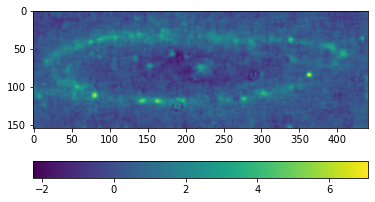

In [37]:
fig = plt.figure
plt.imshow(data)
plt.colorbar(orientation="horizontal")
plt

In [38]:
#mask center coords and turn 2d arrays into lists of 1d arrays
th_range = [0.002, np.pi]
mask = create_mask(THETA, th_range, coords=(AX_N, AX_n))

In [77]:
print(mask.shape)
print(mask[0,0])
print(mask[77, 220])
#coords of spots to fit
ind_guess = [(183, 56), (153, 72), (133, 62)] #(200, 57), (340, 60), (300, 80)]
spot_params = [(ax_N[ind[0]], ax_n[ind[1]], 1, HPBW/2) for ind in ind_guess]
spot_params_ls = [[tup[i] for i in range(len(spot_params[0]))] for tup in spot_params]
spot_params_flat = []
for lis in spot_params_ls:
    spot_params_flat += lis
print(spot_params_flat)

(155, 441)
True
False
[-0.002690716070505668, -0.0015271631751518657, 1, 0.0002181661564992912, -0.004872377749294048, -0.00036361027979806324, 1, 0.0002181661564992912, -0.006326818868486301, -0.0010908308393941897, 1, 0.0002181661564992912]


In [40]:
spot_ls = [[spot_params_flat[4*i0 + i] for i in range(4)] for i0 in range(int(len(spot_params_flat)/4))]
print(spot_ls)

[[-0.002908882238384506, -0.0015998852311114782, 1, 0.0002181661564992912], [-0.005090543917172886, -0.0005090543917172885, 1, 0.0002181661564992912], [-0.006544985036365138, -0.0010908308393941897, 1, 0.0002181661564992912], [-0.001454441119192253, -0.001454441119192253, 1, 0.0002181661564992912], [0.008726646715153517, -0.001236274951313415, 1, 0.0002181661564992912], [0.005817764476769012, 0.00021816616787883794, 1, 0.0002181661564992912]]


In [95]:
#convert images and coords to 1d array
data_ar = im_to_1d(data_ma)
#fakedata_ar = im_to_1d(fakedata_ma)
model_ar = im_to_1d(model_ma)
THETA_ar = im_to_1d(THETA_ma)
AXN_ar = im_to_1d(AXN_ma)
AXn_ar = im_to_1d(AXn_ma)
x = [AXN_ar, AXn_ar] 
w_all = []
chi_all = []

[1.0e+00 1.0e+00 1.6e+01 1.5e-02 1.0e-06]


[-2.31965890e-02  1.23486161e+00  1.83763379e+01  1.41023366e-02
  9.17180337e-06 -2.75064952e-03 -1.48750976e-03  1.26039414e+00
  1.79832661e-04 -4.86074251e-03 -2.86754828e-04  1.28425440e+00
  2.24452417e-04 -6.28819137e-03 -9.93125869e-04  1.25974625e+00
  2.02801553e-04]


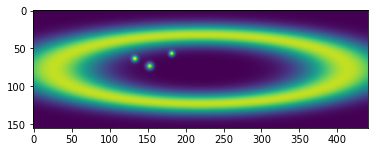

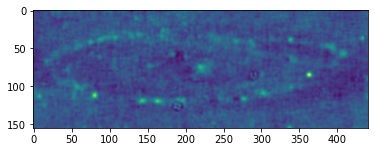

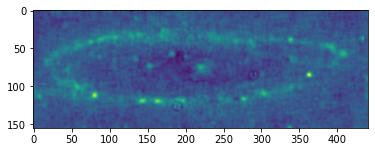

In [88]:
ellipse_and_uniform = [1, 1, 16, 0.015, 1e-6]
#w_init = np.array(ellipse_and_uniform+spot_params_flat)
#w_init = np.array([ 4.16221811e-01,  4.16265548e-01,  1.71675032e+01,  1.37037797e-02,
#                   5.71298810e-06, -2.74069026e-03, -1.48581756e-03,  7.08124137e-01,
#                   1.63360157e-04, -4.86570910e-03, -2.80229101e-04,  7.48761789e-01,
#                   1.83967716e-04, -6.24721968e-03, -9.71450284e-04,  7.08124129e-01,
#                   1.74118357e-04])

w_init = np.array([-2.31965890e-02,  1.23486161e+00,  1.83763379e+01,  1.41023366e-02,
                    9.17180337e-06, -2.75064952e-03, -1.48750976e-03,  1.26039414e+00,
                    1.79832661e-04, -4.86074251e-03, -2.86754828e-04,  1.28425440e+00,
                    2.24452417e-04, -6.28819137e-03, -9.93125869e-04,  1.25974625e+00,
                    2.02801553e-04])
print(w_init)
plt.imshow(f([AX_N, AX_n], w_init))
fig = plt.figure()
plt.imshow(data-f([AX_N, AX_n], w_init))
fig = plt.figure()
plt.imshow(data)

In [89]:
this_chi2 = chi2(w_init, *(data, [AX_N, AX_n],  noise, mask))
statement1 = 'initial weights are: '
for j in range(len(w_init)):
    statement1 += 'w' + str(j) + ' = ' + str(w_init[j]) + '; '
print(statement1)
print('chi^2 = ' + str(this_chi2))
# update weights
bnds_ue = [(-1, 3), (-1, 2), (10, 20), (.005 , 0.025), (5e-7, 2e-5)]
bnds_pts = []
for point in spot_params_ls:
    bnds_pts+= [(point[0]-2*HPBW, point[0]+2*HPBW), (point[1]-2*HPBW, point[1]+2*HPBW), (0, 2), (HPBW/3, 2*HPBW)]
bnds = bnds_ue+bnds_pts
print(bnds)
res = minimize(chi2, w_init, args=(data, [AX_N, AX_n], noise, mask), bounds=bnds)

initial weights are: w0 = -0.023196589; w1 = 1.23486161; w2 = 18.3763379; w3 = 0.0141023366; w4 = 9.17180337e-06; w5 = -0.00275064952; w6 = -0.00148750976; w7 = 1.26039414; w8 = 0.000179832661; w9 = -0.00486074251; w10 = -0.000286754828; w11 = 1.2842544; w12 = 0.000224452417; w13 = -0.00628819137; w14 = -0.000993125869; w15 = 1.25974625; w16 = 0.000202801553; 
chi^2 = 277856.0298706896
[(-1, 3), (-1, 2), (10, 20), (0.005, 0.025), (5e-07, 2e-05), (-0.0035633806965028325, -0.0018180514445085031), (-0.0023998278011490306, -0.0006544985491547009), (0, 2), (0.0001454441043328608, 0.0008726646259971648), (-0.005745042375291213, -0.0039997131232968825), (-0.001236274905795228, 0.0005090543461991016), (0, 2), (0.0001454441043328608, 0.0008726646259971648), (-0.007199483494483466, -0.005454154242489136), (-0.0019634954653913544, -0.00021816621339702488), (0, 2), (0.0001454441043328608, 0.0008726646259971648)]


[-1.42986230e-02  1.22828389e+00  1.83811167e+01  1.40851020e-02
  8.97638384e-06 -2.75273913e-03 -1.48370664e-03  1.26257098e+00
  1.76127050e-04 -4.86345728e-03 -2.83264144e-04  1.28636102e+00
  2.23931864e-04 -6.28309669e-03 -9.99206793e-04  1.26192499e+00
  2.07870457e-04]
True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
final: 277836.7279849949


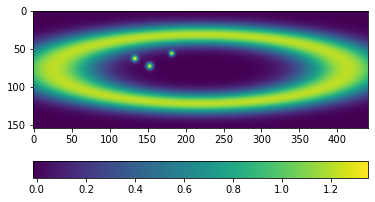

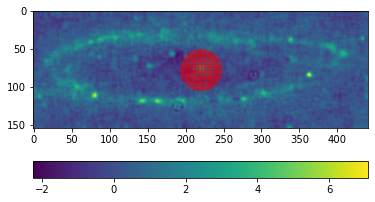

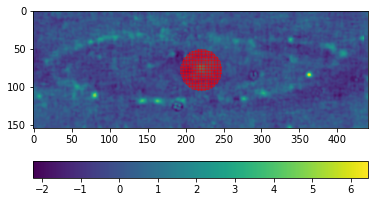

In [90]:
w_fin = res.x
print(w_fin)
print(res.success)
print(res.message)
chi2_final = chi2(w_fin, *(data, [AX_N, AX_n], noise, mask))
print('final: '+ str(chi2_final)) 
fig = plt.figure()
new_model = f([AX_N, AX_n], w_fin)
plt.imshow(new_model) 
plt.colorbar(orientation='horizontal')
fig = plt.figure()
plt.imshow(data)
plt.colorbar(orientation='horizontal')
plt.scatter(ind[1], ind[0], s=1/64, color='r')
fig = plt.figure()
plt.imshow(data-new_model)
plt.colorbar(orientation='horizontal')
plt.scatter(ind[1], ind[0], s=1/64, color='r')

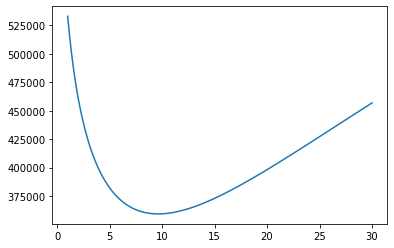

In [109]:
num_pts = 500
w0 = np.linspace(-1, 1, num_pts)
w1 = np.linspace(0, 2, num_pts)
w2 = np.linspace(9, 25, num_pts)
w3 = np.linspace(.01, .03, num_pts)
w4 = np.linspace(1e-6, 3e-5, num_pts)
chi2_w = np.array([chi2([w_fin[0], w_fin[1], w_fin[2], w_fin[3], w4[i], *(data_ar, x, sigma)) for i in range(num_pts)])
plt.plot(w4, chi2_w)

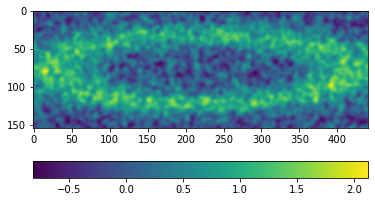

In [112]:
#load fake data
frac=3.2
sample_num = 1000
file_name = base_path + 'fake_residuals/sigma_rms_'+ str(sigma)\
 + '_spacing_' + '{:.2e}'.format(dlt_N/frac) + '_samplenum_' + str(sample_num) + '.npy'
resid = np.load(file_name)
#inject ring
num_params = 5
w = [w_fin[i]*w_scales[i] for i in range(num_params)]
model = f([AX_N, AX_n], w)
#fake_data = resid+model
fake_data = model+resid
fig = plt.figure()
plt.imshow(fake_data)
plt.colorbar(orientation="horizontal")